# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the network flow dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from importlib import reload
import os
import utils, models
reload(utils)
reload(models)
from utils import model_inputs, get_flow_dataset
from models import generator, discriminator

In [3]:
benign, attack = get_flow_dataset(os.path.join('data', 'ids2017_sampled.csv'))

In [4]:
benign.shape

(1500, 47)

In [5]:
attack.shape

(1650, 47)

## Hyperparameters

In [6]:
# Size of input flow to discriminator
input_size = benign.shape[1]
# Size of latent vector to generator
z_size = 2
# Sizes of hidden layers in generator and discriminator
g_hidden_size = [128, 64]
d_hidden_size = [128, 64]
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

## Build network

Now we're building the network from the functions defined above.

First is to get our inputs, `input_benign, input_z, input_attack_remains` from `model_inputs` using the sizes of the input and z.

Then, we'll create the generator, `generator(input_z, z_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for benign flow data and one for attack flow data. Since we want the weights to be the same for both benign and attack flow data, we need to reuse the variables. For the attack flow data, we're getting it from the output of the generator concatenated with remaining part of attack feature called `g_model`. So the benign data discriminator is `discriminator(input_benign)` while the attack discriminator is `discriminator(g_model, reuse=True)`.

In [7]:
tf.reset_default_graph()

# Create our input placeholders
input_benign, input_z, input_attack_remains = model_inputs(input_size, z_size, attack_remains_dim=input_size - z_size)

# Build the model
z_generated, g_hidden = generator(input_z, z_size, n_units=[z_size] + g_hidden_size, alpha=alpha)
g_model = tf.concat([z_generated, input_attack_remains], 1)
# g_model is the generator output concatenated with the remaining part of attack features

d_model_benign, d_logits_benign, d_hidden_benign = discriminator(input_benign,
                                                                 n_units= [input_size] + d_hidden_size,
                                                                 alpha=alpha)
d_model_attack, d_logits_attack, d_hidden_attack = discriminator(g_model,
                                                                 reuse=True,
                                                                 n_units=[input_size] + d_hidden_size,
                                                                 alpha=alpha)

## Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for benign and attack flows, `d_loss = d_loss_benign + d_loss_attack`. The losses will by sigmoid cross-entropys, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the flows in the batch. So the losses will look something like 

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the benign flow logits, we'll use `d_logits_benign` which we got from the discriminator in the cell above. For the labels, we want them to be all zeros, since these are all benign flows. In TensorFlow, it looks something like `labels = tf.zeros_like(tensor)`

The discriminator loss for the attack flow data is similar. The logits are `d_logits_attack`, which we got from passing the generator output concatenated with remaing part of attack flow features to the discriminator. These attack logits are used with labels of all ones. Remember that we want the discriminator to output 0 for benign flows and 1 for attack flows, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_attack`, the attack flow logits. But, now the labels are all zeros. The generator is trying to fool the discriminator, so it wants to discriminator to output zeros for attack flows.

In [8]:
# Calculate losses
d_loss_benign = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_benign, 
                                                          labels=tf.zeros_like(d_logits_benign)))
d_loss_attack = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack, 
                                                          labels=tf.ones_like(d_logits_attack)))
d_loss = d_loss_benign + d_loss_attack

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack,
                                                     labels=tf.zeros_like(d_logits_attack)))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables to start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to `var_list` in the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

In [9]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [10]:
from copy import deepcopy
import time

batch_size = 100
epochs = 1000
losses = []
original_flows, generated_flows, attack_scores = [], [], []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        start = time.time()
        np.random.shuffle(benign)
        np.random.shuffle(attack)
        original_flows.append([])
        generated_flows.append([])
        attack_scores.append([])
        for ii in range(benign.shape[0]//batch_size):
            batch_benign = benign[ii * batch_size:(ii + 1) * batch_size]
            
            batch_attack = attack[ii * batch_size:(ii + 1) * batch_size]
            batch_z = batch_attack[:,:z_size]
            batch_attack_remains = batch_attack[:,z_size:]
            
            if ii % 5 == 0:
                original_flow = batch_attack
                generated_flow = sess.run(g_model, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                attack_score = sess.run(d_model_attack, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                original_flows[-1].append(deepcopy(original_flow[0]))
                generated_flows[-1].append(generated_flow[0])
                attack_scores[-1].append(attack_score[0][0])
                
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_benign: batch_benign, input_z: batch_z, input_attack_remains: batch_attack_remains})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_benign: batch_benign, input_attack_remains: batch_attack_remains})
        train_loss_g = g_loss.eval({input_z: batch_z, input_attack_remains: batch_attack_remains})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g),
              "Time elapsed: {:.4f}".format(time.time() - start)
             )    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        saver.save(sess, './checkpoints/generator.ckpt')

Epoch 1/1000... Discriminator Loss: 35625.0245... Generator Loss: 4989196.5265 Time elapsed: 0.6790
Epoch 2/1000... Discriminator Loss: 12222.2017... Generator Loss: 5649139.7609 Time elapsed: 0.0718
Epoch 3/1000... Discriminator Loss: 21621.6646... Generator Loss: 4746889.6690 Time elapsed: 0.0917
Epoch 4/1000... Discriminator Loss: 10214.7433... Generator Loss: 3009332.4778 Time elapsed: 0.0799
Epoch 5/1000... Discriminator Loss: 14850.9006... Generator Loss: 2471593.3352 Time elapsed: 0.0750
Epoch 6/1000... Discriminator Loss: 23298.9130... Generator Loss: 2528163.1483 Time elapsed: 0.0745
Epoch 7/1000... Discriminator Loss: 2246.8251... Generator Loss: 1356260.4635 Time elapsed: 0.0816
Epoch 8/1000... Discriminator Loss: 4373.0540... Generator Loss: 1920188.1581 Time elapsed: 0.0746
Epoch 9/1000... Discriminator Loss: 1800.0204... Generator Loss: 1620094.1156 Time elapsed: 0.0870
Epoch 10/1000... Discriminator Loss: 2816.3538... Generator Loss: 1923226.8653 Time elapsed: 0.0771
Epo

Epoch 85/1000... Discriminator Loss: 283.6331... Generator Loss: 3021289.5149 Time elapsed: 0.0747
Epoch 86/1000... Discriminator Loss: 288.2665... Generator Loss: 3018794.5464 Time elapsed: 0.0813
Epoch 87/1000... Discriminator Loss: 4.9445... Generator Loss: 3288473.7595 Time elapsed: 0.0777
Epoch 88/1000... Discriminator Loss: 1.0531... Generator Loss: 2516110.3065 Time elapsed: 0.0752
Epoch 89/1000... Discriminator Loss: 0.0000... Generator Loss: 3507194.4597 Time elapsed: 0.0732
Epoch 90/1000... Discriminator Loss: 73.6560... Generator Loss: 2727758.0234 Time elapsed: 0.0778
Epoch 91/1000... Discriminator Loss: 442.1357... Generator Loss: 3010494.9599 Time elapsed: 0.0806
Epoch 92/1000... Discriminator Loss: 0.0000... Generator Loss: 3108259.8855 Time elapsed: 0.0761
Epoch 93/1000... Discriminator Loss: 123.4225... Generator Loss: 2873051.9908 Time elapsed: 0.0750
Epoch 94/1000... Discriminator Loss: 397.9902... Generator Loss: 2602037.0803 Time elapsed: 0.0834
Epoch 95/1000... Di

Epoch 169/1000... Discriminator Loss: 0.0000... Generator Loss: 2013896.1225 Time elapsed: 0.0837
Epoch 170/1000... Discriminator Loss: 0.8167... Generator Loss: 1912248.2951 Time elapsed: 0.0780
Epoch 171/1000... Discriminator Loss: 142.7053... Generator Loss: 2451911.0902 Time elapsed: 0.0778
Epoch 172/1000... Discriminator Loss: 0.0000... Generator Loss: 1491334.3156 Time elapsed: 0.0762
Epoch 173/1000... Discriminator Loss: 74.3365... Generator Loss: 2845132.0784 Time elapsed: 0.0769
Epoch 174/1000... Discriminator Loss: 0.0000... Generator Loss: 2928936.1906 Time elapsed: 0.0876
Epoch 175/1000... Discriminator Loss: 0.0000... Generator Loss: 3617796.5556 Time elapsed: 0.0753
Epoch 176/1000... Discriminator Loss: 0.0000... Generator Loss: 3642292.3634 Time elapsed: 0.0765
Epoch 177/1000... Discriminator Loss: 0.0000... Generator Loss: 2290569.7151 Time elapsed: 0.0790
Epoch 178/1000... Discriminator Loss: 0.0000... Generator Loss: 3175355.6747 Time elapsed: 0.0807
Epoch 179/1000...

Epoch 254/1000... Discriminator Loss: 0.0000... Generator Loss: 2106743.2456 Time elapsed: 0.0765
Epoch 255/1000... Discriminator Loss: 0.0000... Generator Loss: 1615828.0380 Time elapsed: 0.0812
Epoch 256/1000... Discriminator Loss: 0.0000... Generator Loss: 1449858.8265 Time elapsed: 0.0728
Epoch 257/1000... Discriminator Loss: 25.9348... Generator Loss: 1372583.7864 Time elapsed: 0.0878
Epoch 258/1000... Discriminator Loss: 0.0000... Generator Loss: 1257816.2131 Time elapsed: 0.0785
Epoch 259/1000... Discriminator Loss: 0.0000... Generator Loss: 1665127.0345 Time elapsed: 0.0847
Epoch 260/1000... Discriminator Loss: 175.2553... Generator Loss: 1420754.5296 Time elapsed: 0.0773
Epoch 261/1000... Discriminator Loss: 0.0000... Generator Loss: 2094357.5127 Time elapsed: 0.0881
Epoch 262/1000... Discriminator Loss: 0.0000... Generator Loss: 1683617.4042 Time elapsed: 0.0769
Epoch 263/1000... Discriminator Loss: 0.0000... Generator Loss: 1618372.5431 Time elapsed: 0.0891
Epoch 264/1000...

Epoch 338/1000... Discriminator Loss: 0.0000... Generator Loss: 1115562.1657 Time elapsed: 0.0756
Epoch 339/1000... Discriminator Loss: 0.0000... Generator Loss: 1699738.3592 Time elapsed: 0.0767
Epoch 340/1000... Discriminator Loss: 0.0000... Generator Loss: 1375534.2149 Time elapsed: 0.0814
Epoch 341/1000... Discriminator Loss: 0.0000... Generator Loss: 2047920.4135 Time elapsed: 0.0790
Epoch 342/1000... Discriminator Loss: 0.0000... Generator Loss: 1005410.1942 Time elapsed: 0.0774
Epoch 343/1000... Discriminator Loss: 0.0000... Generator Loss: 1363661.2454 Time elapsed: 0.0831
Epoch 344/1000... Discriminator Loss: 0.0000... Generator Loss: 1518707.5944 Time elapsed: 0.0825
Epoch 345/1000... Discriminator Loss: 0.0000... Generator Loss: 1444745.8250 Time elapsed: 0.0812
Epoch 346/1000... Discriminator Loss: 0.0000... Generator Loss: 1116637.3201 Time elapsed: 0.0807
Epoch 347/1000... Discriminator Loss: 0.0000... Generator Loss: 1023076.2753 Time elapsed: 0.0750
Epoch 348/1000... Di

Epoch 422/1000... Discriminator Loss: 0.0000... Generator Loss: 1086139.3385 Time elapsed: 0.0787
Epoch 423/1000... Discriminator Loss: 0.0000... Generator Loss: 1204265.0745 Time elapsed: 0.0739
Epoch 424/1000... Discriminator Loss: 0.0000... Generator Loss: 1840253.7580 Time elapsed: 0.0778
Epoch 425/1000... Discriminator Loss: 0.0000... Generator Loss: 1718370.8037 Time elapsed: 0.0740
Epoch 426/1000... Discriminator Loss: 0.0000... Generator Loss: 1123110.6704 Time elapsed: 0.0877
Epoch 427/1000... Discriminator Loss: 0.0000... Generator Loss: 1324244.5892 Time elapsed: 0.0815
Epoch 428/1000... Discriminator Loss: 0.0000... Generator Loss: 1253461.6648 Time elapsed: 0.0844
Epoch 429/1000... Discriminator Loss: 0.0000... Generator Loss: 1125561.4422 Time elapsed: 0.0810
Epoch 430/1000... Discriminator Loss: 0.0000... Generator Loss: 1359486.0631 Time elapsed: 0.0753
Epoch 431/1000... Discriminator Loss: 0.0000... Generator Loss: 1560974.8750 Time elapsed: 0.0793
Epoch 432/1000... Di

Epoch 506/1000... Discriminator Loss: 0.0000... Generator Loss: 1259115.2059 Time elapsed: 0.0814
Epoch 507/1000... Discriminator Loss: 0.0000... Generator Loss: 1502013.6838 Time elapsed: 0.0876
Epoch 508/1000... Discriminator Loss: 0.0000... Generator Loss: 1490600.0469 Time elapsed: 0.0805
Epoch 509/1000... Discriminator Loss: 0.0000... Generator Loss: 1116984.2419 Time elapsed: 0.0800
Epoch 510/1000... Discriminator Loss: 0.0000... Generator Loss: 1552613.5034 Time elapsed: 0.0755
Epoch 511/1000... Discriminator Loss: 0.0000... Generator Loss: 1371399.8355 Time elapsed: 0.0867
Epoch 512/1000... Discriminator Loss: 0.0000... Generator Loss: 1710652.4812 Time elapsed: 0.0788
Epoch 513/1000... Discriminator Loss: 0.0000... Generator Loss: 1565878.2027 Time elapsed: 0.0760
Epoch 514/1000... Discriminator Loss: 0.0000... Generator Loss: 1220796.8945 Time elapsed: 0.0894
Epoch 515/1000... Discriminator Loss: 0.0000... Generator Loss: 1149750.8930 Time elapsed: 0.0814
Epoch 516/1000... Di

Epoch 590/1000... Discriminator Loss: 0.0000... Generator Loss: 1835974.3220 Time elapsed: 0.0769
Epoch 591/1000... Discriminator Loss: 0.0000... Generator Loss: 1064054.3080 Time elapsed: 0.0770
Epoch 592/1000... Discriminator Loss: 0.0000... Generator Loss: 1525080.4894 Time elapsed: 0.0726
Epoch 593/1000... Discriminator Loss: 0.0000... Generator Loss: 1194825.4548 Time elapsed: 0.0896
Epoch 594/1000... Discriminator Loss: 0.0000... Generator Loss: 1202533.5028 Time elapsed: 0.0782
Epoch 595/1000... Discriminator Loss: 0.0000... Generator Loss: 1167507.7526 Time elapsed: 0.0788
Epoch 596/1000... Discriminator Loss: 0.0000... Generator Loss: 1199951.6845 Time elapsed: 0.0762
Epoch 597/1000... Discriminator Loss: 0.0000... Generator Loss: 1751437.7888 Time elapsed: 0.0758
Epoch 598/1000... Discriminator Loss: 0.0000... Generator Loss: 1550499.6613 Time elapsed: 0.0782
Epoch 599/1000... Discriminator Loss: 0.0000... Generator Loss: 1040567.7334 Time elapsed: 0.0795
Epoch 600/1000... Di

Epoch 675/1000... Discriminator Loss: 0.0000... Generator Loss: 1480882.1080 Time elapsed: 0.0806
Epoch 676/1000... Discriminator Loss: 0.0000... Generator Loss: 1190192.1175 Time elapsed: 0.0795
Epoch 677/1000... Discriminator Loss: 0.0000... Generator Loss: 1191077.3525 Time elapsed: 0.0766
Epoch 678/1000... Discriminator Loss: 0.0000... Generator Loss: 1645403.7449 Time elapsed: 0.0748
Epoch 679/1000... Discriminator Loss: 0.0000... Generator Loss: 1560471.4571 Time elapsed: 0.0782
Epoch 680/1000... Discriminator Loss: 0.0000... Generator Loss: 1209153.1998 Time elapsed: 0.0807
Epoch 681/1000... Discriminator Loss: 0.0000... Generator Loss: 1071939.7752 Time elapsed: 0.0894
Epoch 682/1000... Discriminator Loss: 0.0000... Generator Loss: 1322635.5853 Time elapsed: 0.0847
Epoch 683/1000... Discriminator Loss: 0.0000... Generator Loss: 1383015.3245 Time elapsed: 0.0749
Epoch 684/1000... Discriminator Loss: 0.0000... Generator Loss: 1556345.0013 Time elapsed: 0.0844
Epoch 685/1000... Di

Epoch 760/1000... Discriminator Loss: 0.0000... Generator Loss: 1588475.4283 Time elapsed: 0.0775
Epoch 761/1000... Discriminator Loss: 0.0000... Generator Loss: 1576508.9740 Time elapsed: 0.0790
Epoch 762/1000... Discriminator Loss: 0.0000... Generator Loss: 1336350.1593 Time elapsed: 0.0762
Epoch 763/1000... Discriminator Loss: 0.0000... Generator Loss: 967446.6080 Time elapsed: 0.0801
Epoch 764/1000... Discriminator Loss: 0.0000... Generator Loss: 1534861.8788 Time elapsed: 0.0854
Epoch 765/1000... Discriminator Loss: 0.0000... Generator Loss: 1236977.2438 Time elapsed: 0.0790
Epoch 766/1000... Discriminator Loss: 0.0000... Generator Loss: 1605117.6920 Time elapsed: 0.0774
Epoch 767/1000... Discriminator Loss: 0.0000... Generator Loss: 1503804.8230 Time elapsed: 0.0803
Epoch 768/1000... Discriminator Loss: 0.0000... Generator Loss: 1337546.3663 Time elapsed: 0.0796
Epoch 769/1000... Discriminator Loss: 0.0000... Generator Loss: 1379247.3717 Time elapsed: 0.0808
Epoch 770/1000... Dis

Epoch 844/1000... Discriminator Loss: 0.0000... Generator Loss: 1245035.2926 Time elapsed: 0.0740
Epoch 845/1000... Discriminator Loss: 0.0000... Generator Loss: 1679307.3242 Time elapsed: 0.0778
Epoch 846/1000... Discriminator Loss: 0.0000... Generator Loss: 1350240.1942 Time elapsed: 0.0766
Epoch 847/1000... Discriminator Loss: 0.0000... Generator Loss: 1552803.2102 Time elapsed: 0.0800
Epoch 848/1000... Discriminator Loss: 0.0000... Generator Loss: 1575915.7217 Time elapsed: 0.0791
Epoch 849/1000... Discriminator Loss: 0.0000... Generator Loss: 1089934.6141 Time elapsed: 0.0780
Epoch 850/1000... Discriminator Loss: 0.0000... Generator Loss: 1526125.1963 Time elapsed: 0.0804
Epoch 851/1000... Discriminator Loss: 0.0000... Generator Loss: 1266091.9609 Time elapsed: 0.0773
Epoch 852/1000... Discriminator Loss: 0.0000... Generator Loss: 1780061.9222 Time elapsed: 0.0732
Epoch 853/1000... Discriminator Loss: 0.0000... Generator Loss: 1495516.5424 Time elapsed: 0.0722
Epoch 854/1000... Di

Epoch 928/1000... Discriminator Loss: 0.0000... Generator Loss: 1486285.8341 Time elapsed: 0.0754
Epoch 929/1000... Discriminator Loss: 0.0000... Generator Loss: 2030868.4104 Time elapsed: 0.0865
Epoch 930/1000... Discriminator Loss: 0.0000... Generator Loss: 1855163.0647 Time elapsed: 0.0779
Epoch 931/1000... Discriminator Loss: 0.0000... Generator Loss: 1352777.7926 Time elapsed: 0.0806
Epoch 932/1000... Discriminator Loss: 0.0000... Generator Loss: 1826508.9438 Time elapsed: 0.0740
Epoch 933/1000... Discriminator Loss: 0.0000... Generator Loss: 1786243.4386 Time elapsed: 0.0773
Epoch 934/1000... Discriminator Loss: 0.0000... Generator Loss: 1179585.4124 Time elapsed: 0.0674
Epoch 935/1000... Discriminator Loss: 0.0000... Generator Loss: 1490071.7438 Time elapsed: 0.0718
Epoch 936/1000... Discriminator Loss: 0.0000... Generator Loss: 1273704.3249 Time elapsed: 0.0855
Epoch 937/1000... Discriminator Loss: 0.0000... Generator Loss: 1454260.8434 Time elapsed: 0.0785
Epoch 938/1000... Di

## Training loss

Here we'll check out the training losses for the generator and discriminator.

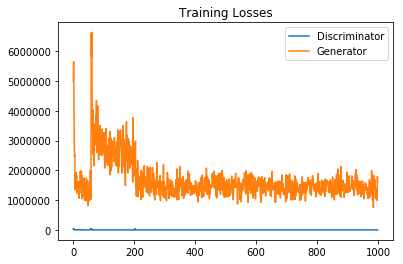

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [12]:
import math

def split_to_two_nearest_factor(x):
    sqrt_x = int(math.sqrt(x))
    i = sqrt_x
    while x % i != 0:
        i -= 1
    return (i, x // i)

In [13]:
fig_size = split_to_two_nearest_factor(input_size)

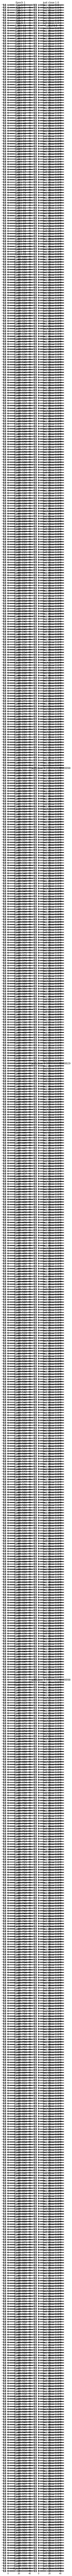

Fooled rate: 0.001


In [14]:
import numpy as np
import matplotlib.pyplot as plt

fooled = 0

# fig=plt.figure(figsize=(fig_size[0] * 5, fig_size[1] * 5))
# columns = 2
rows = len(original_flows)
for i in range(rows):
#     original_img = original_flows[i][0]
#     generated_img = generated_flows[i][0]
#     ax_original = fig.add_subplot(rows, columns, i * 2 + 1)
#     ax_original.set_title('Epoch {epoch}'.format(epoch=i + 1))
#     plt.imshow(original_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
#     ax_generated = fig.add_subplot(rows, columns, i * 2 + 2)
#     plt.imshow(generated_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
    if attack_scores[i][0] <= 0.5:
#         ax_generated.set_title('Fooled:' + str(attack_scores[i][0]))
        fooled += 1
#     else:
#         ax_generated.set_title('Just close:' + str(attack_scores[i][0]))
plt.show()
print('Fooled rate:', fooled / len(original_flows))